In [5]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
Refer = pd.read_csv('RiverReferenceTable.csv')
Discharge = pd.read_csv('Historical/HistoricalDischarge.csv')
Precip = pd.read_csv('Historical/HistoricalPrecip.csv')
Discharge['Date'] = pd.to_datetime(Discharge.DateTime).dt.date
Discharge = Discharge.set_index('Name').join(Refer.set_index('USGS Name')).reset_index()[[
    'Date','Value','VariableDescription','Name','RiverName','FishType']]
Avg_Discharge = Discharge.groupby(['Date','Name','RiverName','FishType']).mean().reset_index()
Avg_Discharge = Avg_Discharge.loc[Avg_Discharge.Value>0]
Precip = Precip.set_index('Name').join(Refer.set_index('Name')).reset_index()[[
    'Date','Precip','Name','RiverName','FishType']]

<AxesSubplot:xlabel='Date', ylabel='Value'>

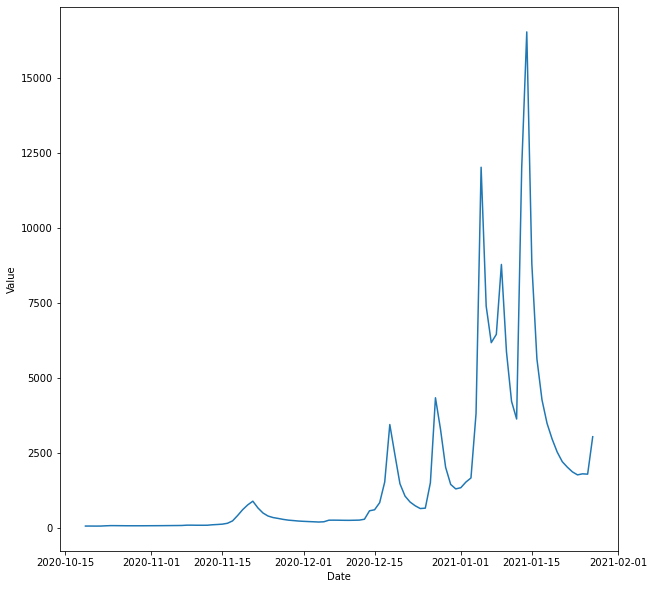

In [6]:
eel = Avg_Discharge.loc[Avg_Discharge['Name']=='Eel River Scotia']
plt.figure(figsize=(10,10))
sns.lineplot(x=eel.Date,y=eel.Value)

[ 1  5 20 33 49 60 69 78 82 87 98]


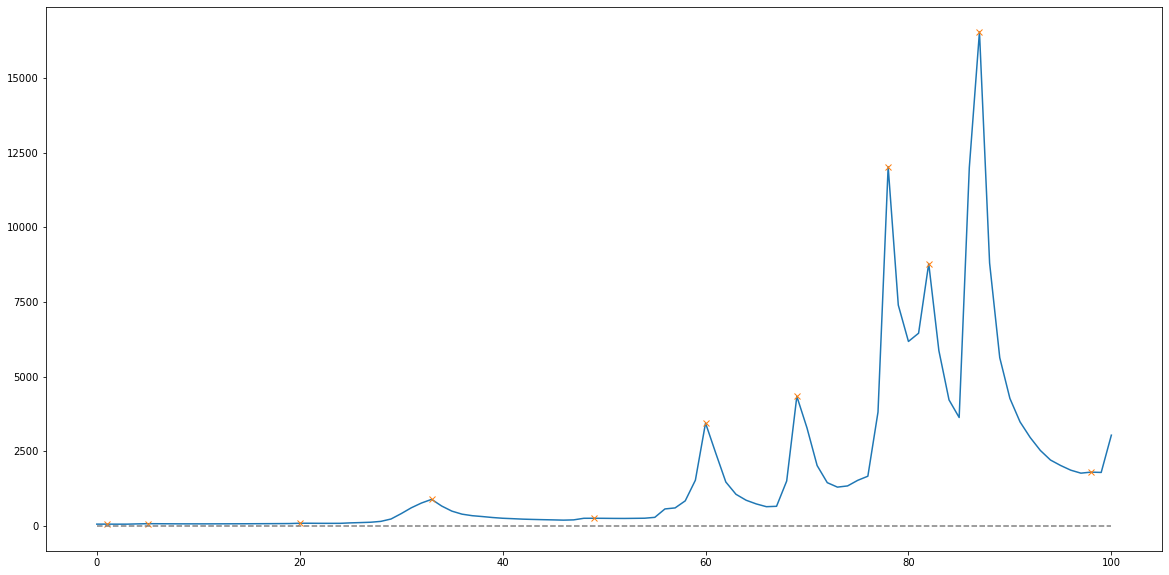

In [7]:
plt.figure(figsize=(20,10))
from scipy.signal import find_peaks
import numpy as np
x = eel.Value.values
peaks, _ = find_peaks(x, height=0)
print(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [8]:
from scipy.signal import find_peaks
import numpy as np

# Takes peaks of a time series and find the point where the 
# slope downard begins to decrease in slope.
def FindBestDays(x): # Must be Series
    delta = np.diff(x.values)
    #delta = x.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).values
    flows = x.values
    idx_peaks, _ = find_peaks(flows, height=0)
    ListOfBestDays = []
    for p in idx_peaks:
        div_ValuesAfterRain = list(delta[p:p+10])
        for indexing,v in enumerate(div_ValuesAfterRain):
            if indexing > 0: #Skip the first value in list
                
                if v > div_ValuesAfterRain[indexing-1]:
                    ListOfBestDays.append(indexing+p)
                    break
        
    # How many days after the peak
    lowThreshold = x.mean()
    BestDays = [i for i in ListOfBestDays if x.values[i] > lowThreshold]
    WaitDays = ListOfBestDays-idx_peaks
    return BestDays, flows[BestDays]

In [9]:
FindBestDays(eel.Value)

([61, 71, 79, 83, 88, 99],
 array([2449.89583333, 2026.875     , 7398.125     , 5875.        ,
        8806.04166667, 1795.875     ]))

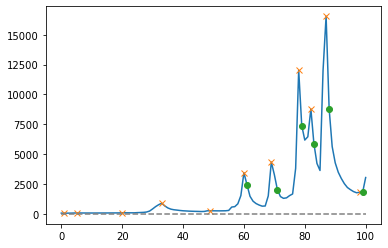

In [10]:
x = eel.Value.values
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.plot(*FindBestDays(eel.Value),"o")
plt.show()

In [11]:
Avg_Discharge.Name.loc[Avg_Discharge['FishType']=='Steelhead'].unique()

array(['Eel River Fort Seward', 'Eel River Scotia', 'Mad River',
       'Mattole River Ettersburg', 'Mattole River Petrolia',
       'Navarro River', 'Nestucca River Beaver',
       'North Umpqua River Winchester', 'Noyo River',
       'Redwood Creek Orick', 'Rogue River Agness',
       'Rogue River Grants Pass', 'Russian River HaciendaBridge',
       'San Lorenzo River', 'San Lorenzo River Upper', 'Smith River CC',
       'Trinity River Burnt Ranch', 'Trinity River Junction City',
       'Trinity River Lewiston', 'Umpqua River Elkton',
       'Van Duzen River Bridgeville'], dtype=object)

In [12]:
fake = Avg_Discharge
# fake = Avg_Discharge.loc[(Avg_Discharge.Name=='Eel River Scotia')|
#                         (Avg_Discharge.Name=='Rogue River Agness')]

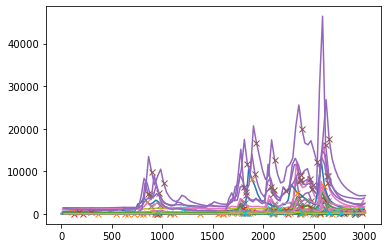

In [13]:
totalpeakValues = pd.Series(dtype='float64')
primetimeValues = pd.Series(dtype='float64')

for i in range(len(fake.Name.unique())):
    x = fake.Value.loc[fake.Name==fake.Name.unique()[i]]
    peaks, _ = find_peaks(x, height=0)
    peak_values = fake.Value.loc[fake.Value.isin(_['peak_heights'])]
    primetime = fake.Value.loc[fake.Value.isin(FindBestDays(x)[1])]
    totalpeakValues = totalpeakValues.append(peak_values)
    primetimeValues = primetimeValues.append(primetime)
    
fake['peaks'] = fake.Value.loc[fake.Value.isin(totalpeakValues.values)]
fake['primetime'] = fake.Value.loc[fake.Value.isin(primetimeValues.values)]

for i in fake.Name.unique():
    plt.plot(fake.loc[fake.Name==i].index,fake.Value.loc[fake.Name==i])
    plt.plot(fake.loc[fake.Name==i].index,fake.primetime.loc[fake.Name==i],"x")
plt.show()

In [14]:
fake.loc[fake.primetime>0]

,Date,Name,RiverName,FishType,Value,peaks,primetime
105,2020-10-22,Putah Creek,Putah Creek,Trout,362.875000,NaN,362.875000
121,2020-10-23,East Walker,East Walker,Trout,57.955208,NaN,57.955208
176,2020-10-24,Truckee River Farad,Truckee,Trout,452.479167,NaN,452.479167
195,2020-10-25,Putah Creek,Putah Creek,Trout,349.416667,NaN,349.416667
211,2020-10-26,East Walker,East Walker,Trout,67.873958,NaN,67.873958
...,...,...,...,...,...,...,...
2951,2021-01-25,Trinity River Junction City,Trinity,Steelhead,380.958333,NaN,380.958333
2960,2021-01-26,Eel River Scotia,Eel,Steelhead,1795.875000,NaN,1795.875000
2971,2021-01-26,Pit River,Pit,Trout,1210.208333,NaN,1210.208333
2973,2021-01-26,Redwood Creek Orick,Redwood Creek,Steelhead,695.770833,NaN,695.770833


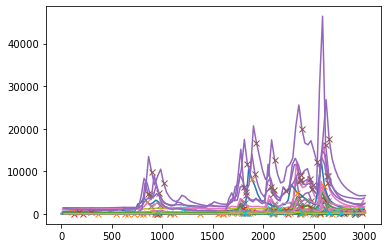

In [15]:
for i in Avg_Discharge.Name.unique():
    plt.plot(Avg_Discharge.loc[Avg_Discharge.Name==i].index,Avg_Discharge.Value.loc[Avg_Discharge.Name==i])
    plt.plot(Avg_Discharge.loc[Avg_Discharge.Name==i].index,Avg_Discharge.primetime.loc[Avg_Discharge.Name==i],"x")
plt.show()

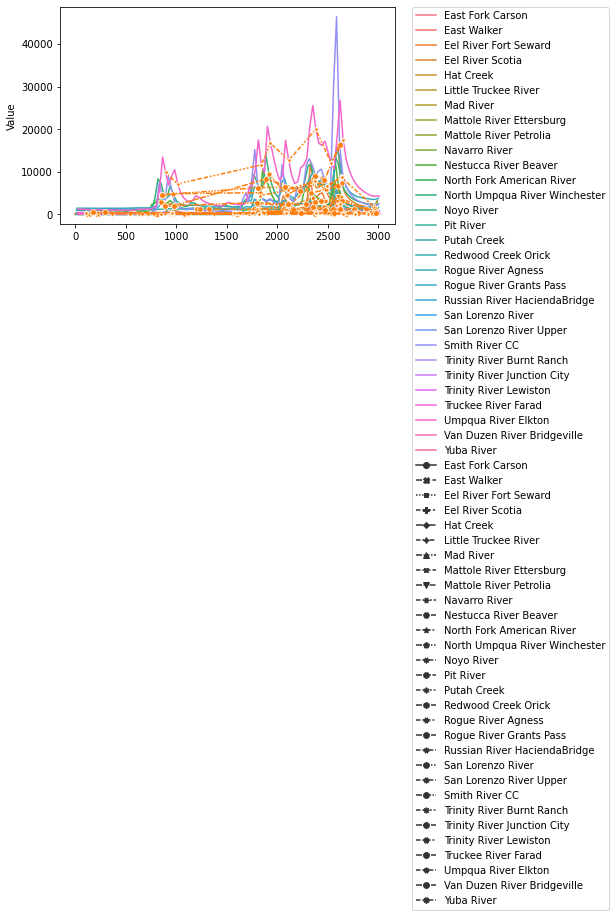

In [16]:
sns.lineplot(x=fake.index,y='Value',data=fake,hue='Name')

sns.lineplot(x=fake.index,y='primetime',data=fake,style='Name', markers=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Where on the line does the slope begin to decrease negative slope

In [17]:
Precip.head()

,Date,Precip,Name,RiverName,FishType
0,2020-10-19,0.0,East Fork Carson,East Fork,Trout
1,2020-10-19,0.0,East Fork Carson,East Fork,Trout
2,2020-10-19,0.0,East Fork Carson,East Fork,Trout
3,2020-10-19,0.0,East Fork Carson,East Fork,Trout
4,2020-10-19,0.0,East Fork Carson,East Fork,Trout
